In [2]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az

In [11]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

**standardize probability of a simple dataset...**

In [4]:
x = np.array([0, 3, 8, 9, 0])
x / x.sum()

array([0.  , 0.15, 0.4 , 0.45, 0.  ])

## calculate likelihood

In [5]:
stats.binom.pmf(6,9,0.5)

0.16406250000000006

## compute posterior probability via grid approximation...

In [70]:
def posterior_grid_approximation(successes, trials, prob_points):
    # define grid
    grid = np.linspace(0,1,prob_points)
    
    # define prior
    prior = np.repeat(0.5, prob_points)
    
    # compute likelihood
    likelihood = stats.binom.pmf(successes, trials, grid)
    
    # computer posterior: product of likelihood and prior
    posterior = likelihood * prior
    
    # standardize posterior (sums to 1)
    posterior = posterior / posterior.sum()
    
    return grid, posterior

**computing posterior with more probability points**

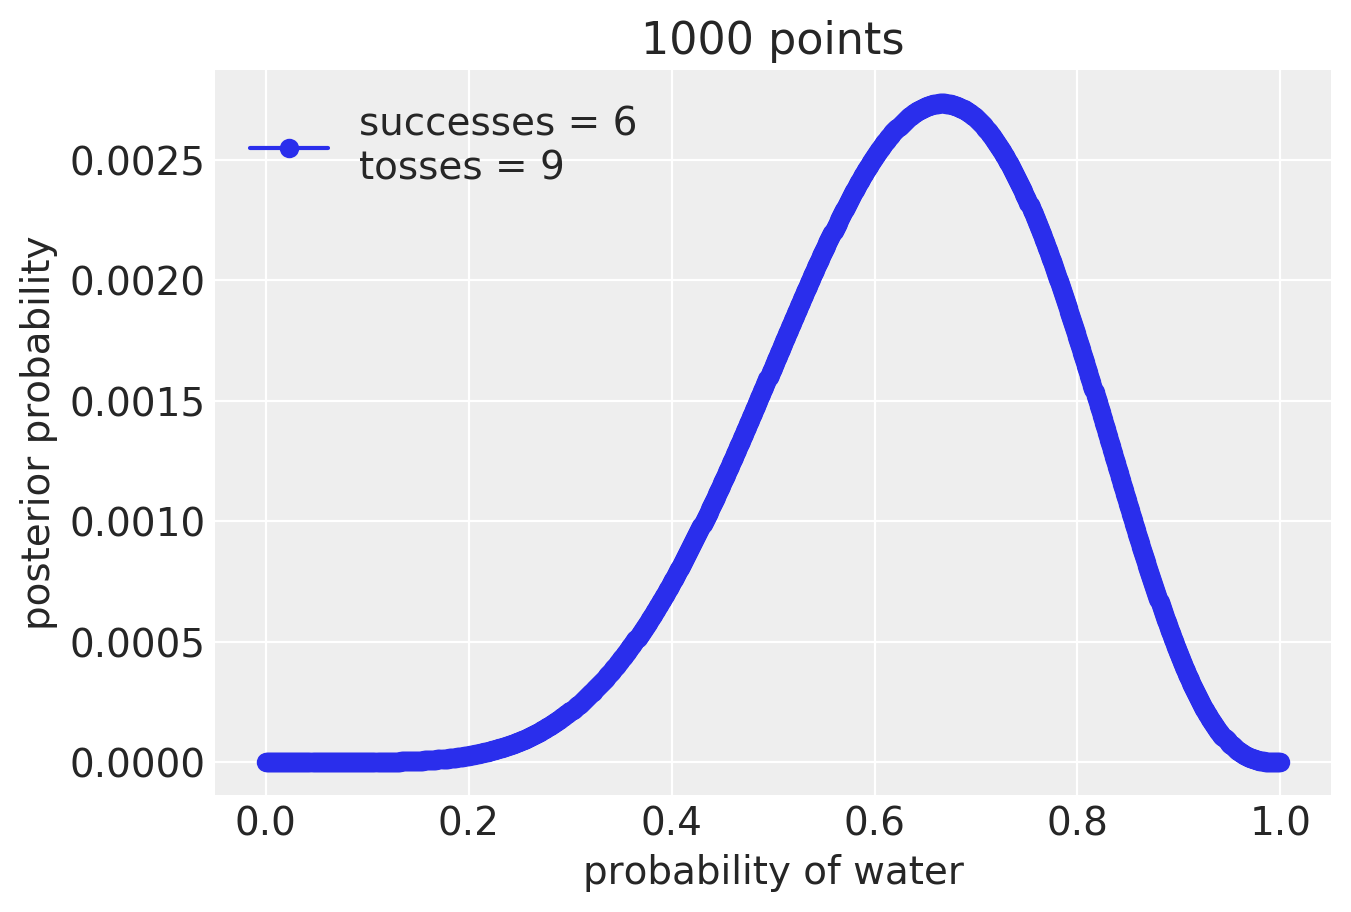

In [71]:
s = 6
n = 9
p = 1000
grid, posterior = posterior_grid_approximation(s,n,p)
plt.plot(grid, posterior, 'o-', label="successes = {}\ntosses = {}".format(s,n))
plt.xlabel('probability of water', fontsize=14)
plt.ylabel('posterior probability', fontsize=14)
plt.title("{} points".format(p))
plt.legend(loc=0)

In [76]:
samples = np.random.choice(grid, p=posterior, size=int(1e5), replace=True)

In [77]:
sum(samples) / 1e5

0.6359918218216435

## computing posterior via quadratic approximation

In [67]:
data = np.repeat((0, 1), (3, 6))
with pm.Model() as normal_approximation:
    
    # Give a uniform prior
    p = pm.Uniform('p', 0, 1)
    
    # Give a binomial likelihood
    w = pm.Binomial('w', n=len(data), p=p, observed=data.sum())
    
    # Maximum a posteriori
    mean_q = pm.find_MAP()
    
    # Standard Deviation
    std_q = ((1/pm.find_hessian(mean_q, vars=[p]))**0.5)[0]
    
    # Sample from the posterior
    trace = pm.sample(2000, tune=1000)
mean_q['p'], std_q

/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -1.8075, ||grad|| = 1.5: 100%|██████████| 7/7 [00:00<00:00, 2427.06it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4493.16draws/s]
The acceptance probability does not match the target. It is 0.8896320657067305, but should be close to 0.8. Try to increase the number of tuning steps.


(array(0.66666667), array([0.15713484]))

**percentile interval**

In [78]:
norm = stats.norm(mean_q, std_q)
prob = .89
z = stats.norm.ppf([(1-prob)/2, (1+prob)/2])
pi = mean_q['p'] + std_q * z 
pi

array([0.41553484, 0.91779849])

## comparing approximations

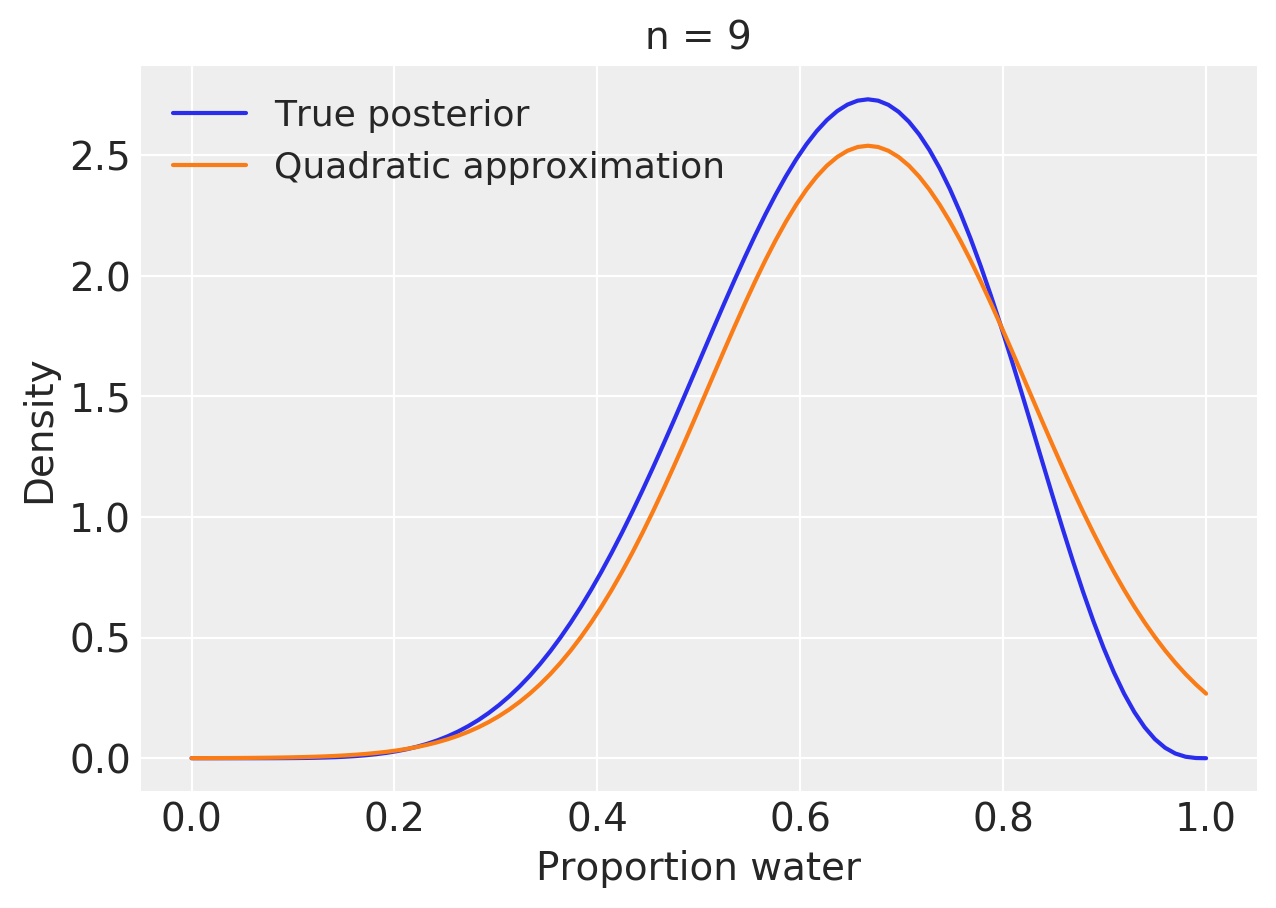

In [80]:
# analytical calculation
w, n = 6, 9
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x , w+1, n-w+1),
         label='True posterior')

# quadratic approximation
plt.plot(x, stats.norm.pdf(x, mean_q['p'], std_q),
         label='Quadratic approximation')
plt.legend(loc=0, fontsize=13)

plt.title('n = {}'.format(n), fontsize=14)
plt.xlabel('Proportion water', fontsize=14)
plt.ylabel('Density', fontsize=14);